In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

In [4]:
tx[:10, :]

array([[ 1.        ,  1.94406149],
       [ 1.        ,  0.62753668],
       [ 1.        ,  2.01244346],
       [ 1.        ,  1.39406046],
       [ 1.        ,  0.9134207 ],
       [ 1.        ,  0.23014782],
       [ 1.        ,  0.6283625 ],
       [ 1.        ,  0.51489027],
       [ 1.        ,  0.16930935],
       [ 1.        , -0.75664459]])

In [5]:
from grid_search import generate_w, get_best_parameters

grid_w0, grid_w1 = generate_w(num_intervals=10)
ys = y[:10]
txs = tx[:10, :]
ws = np.zeros_like(txs) + 0.5

print(ys)
print(ys.shape)
print(txs)
print(txs.shape)
print(ws.T)
print((ws * txs).shape)
vs = np.sum(ws * txs, axis=1)
print(vs)
print(vs)

print(ys - vs)

[109.81967768  73.68895452  96.58434842  99.89928152  93.68280948
  69.10431871  83.50326143  76.25888416  79.87196594  71.00545308]
(10,)
[[ 1.          1.94406149]
 [ 1.          0.62753668]
 [ 1.          2.01244346]
 [ 1.          1.39406046]
 [ 1.          0.9134207 ]
 [ 1.          0.23014782]
 [ 1.          0.6283625 ]
 [ 1.          0.51489027]
 [ 1.          0.16930935]
 [ 1.         -0.75664459]]
(10, 2)
[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]]
(10, 2)
[1.47203075 0.81376834 1.50622173 1.19703023 0.95671035 0.61507391
 0.81418125 0.75744514 0.58465467 0.1216777 ]
[1.47203075 0.81376834 1.50622173 1.19703023 0.95671035 0.61507391
 0.81418125 0.75744514 0.58465467 0.1216777 ]
[108.34764694  72.87518619  95.07812669  98.70225129  92.72609913
  68.4892448   82.68908018  75.50143902  79.28731127  70.88377538]


### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [59]:
def mae(e):
    return np.mean(np.abs(e))

def mse(e):
    return np.mean(e ** 2)

def compute_loss(y, tx, w, L=mse):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """

    e = y - tx @ w
    
    return L(e)


# 2. Grid Search

Fill in the function `grid_search()` below:

In [35]:
losses = np.zeros((5, 5))


In [36]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))

    for i in range(len(grid_w0)):
        for j in range(len(grid_w1)):
            loss = compute_loss(y, tx, np.array([grid_w0[i], grid_w1[j]]))
            losses[i, j] = loss
    
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=6.633376777195036, w0*=73.68421052631578, w1*=7.89473684210526, execution time=0.016 seconds


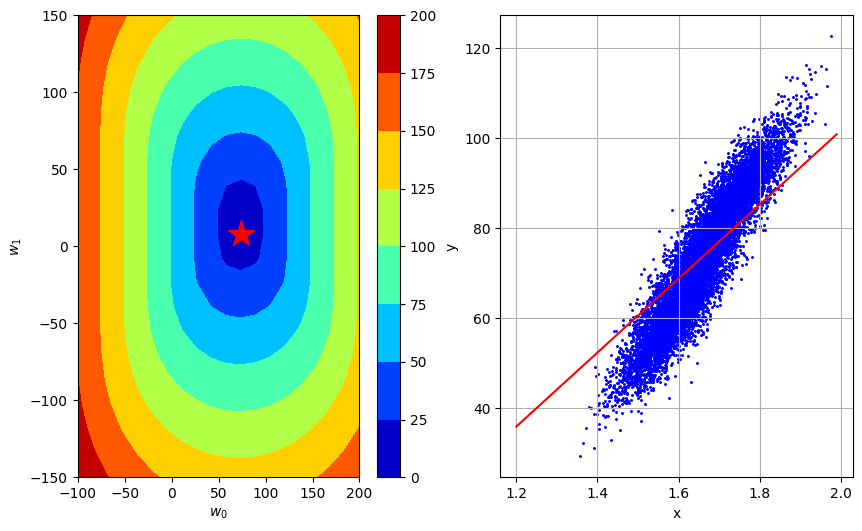

In [9]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=20)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [10]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """

    e = y - tx @ w
    g = -(tx.T @ e) / len(e)
    return g

Please fill in the functions `gradient_descent` below:

In [11]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters + 1 containing the model parameters as numpy arrays of shape (2, ),
            for each iteration of GD (as well as the final weights)
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute gradient and loss
        # ***************************************************
        loss = compute_loss(y, tx, w)
        g = compute_gradient(y, tx, w)

        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by gradient
        # ***************************************************
        w = w - gamma * g

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [12]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=73.29392200210518, w0=51.30574540147367, w1=9.43579870449228
GD iter. 1/49: loss=21.98888659235388, w0=66.69746902191577, w1=12.266538315840014
GD iter. 2/49: loss=7.265302114604064, w0=71.31498610804836, w1=13.115760199244336
GD iter. 3/49: loss=4.699945676696624, w0=72.70024123388815, w1=13.370526764265634
GD iter. 4/49: loss=4.447409765322355, w0=73.11581777164008, w1=13.446956733772023
GD iter. 5/49: loss=4.426368339890847, w0=73.24049073296565, w1=13.469885724623941
GD iter. 6/49: loss=4.424908541814049, w0=73.27789262136334, w1=13.476764421879516
GD iter. 7/49: loss=4.42494113435403, w0=73.28911318788263, w1=13.478828031056189
GD iter. 8/49: loss=4.424986760372248, w0=73.29247935783842, w1=13.47944711380919
GD iter. 9/49: loss=4.425002951094766, w0=73.29348920882516, w1=13.47963283863509
GD iter. 10/49: loss=4.42500808460945, w0=73.29379216412119, w1=13.479688556082861
GD iter. 11/49: loss=4.425009648774413, w0=73.29388305071, w1=13.479705271317192
GD iter. 12

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

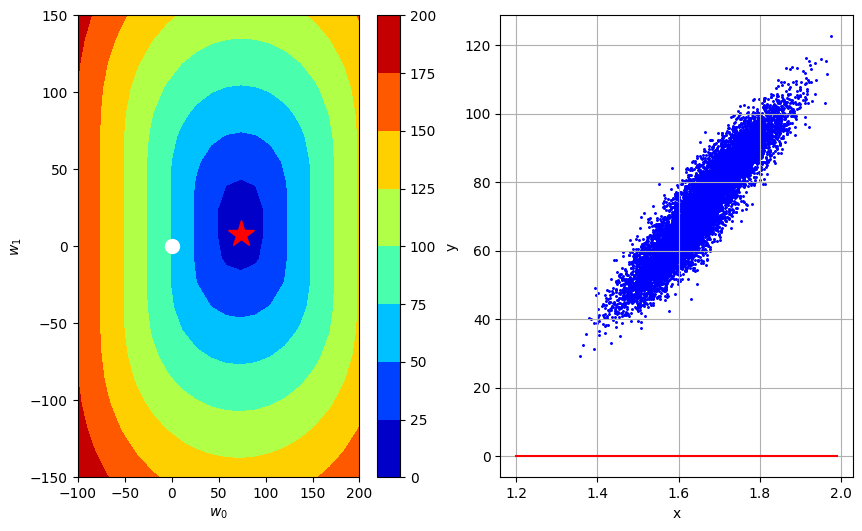

In [13]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 4. Stochastic gradient descent

In [20]:
from helpers import batch_iter

def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """

    e = y - tx @ w
    g = -(tx.T @ e)/len(e)
    return g


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(
            y, tx, batch_size=batch_size, num_batches=1
        ):
            loss = compute_loss(y_batch, tx_batch, w)
            grad = compute_stoch_gradient(y_batch, tx_batch, w)
            w = w - gamma * grad
            

        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [23]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=65.09061939954961, w0=6.509061939954961, w1=-0.4123387114053711
SGD iter. 1/49: loss=63.55749530293795, w0=12.864811470248757, w1=-1.6128623685148573
SGD iter. 2/49: loss=29.10526149793523, w0=15.77533762004228, w1=-5.432661055823741
SGD iter. 3/49: loss=48.92854686748754, w0=20.668192306791035, w1=-8.568034771758906
SGD iter. 4/49: loss=28.602832996740712, w0=23.528475606465108, w1=-11.217916091059266
SGD iter. 5/49: loss=18.412204049575706, w0=25.36969601142268, w1=-12.90113431515799
SGD iter. 6/49: loss=35.50374673488005, w0=28.920070684910684, w1=-12.967711296978438
SGD iter. 7/49: loss=49.098107541541076, w0=33.82988143906479, w1=-9.80864140736497
SGD iter. 8/49: loss=89.49763892433806, w0=42.7796453314986, w1=8.102983399720106
SGD iter. 9/49: loss=41.81257268234211, w0=46.96090259973281, w1=9.879938393659769
SGD iter. 10/49: loss=27.170361879757742, w0=49.677938787708584, w1=11.149903942968532
SGD iter. 11/49: loss=27.753113284652024, w0=52.453250116173784, w

interactive(children=(IntSlider(value=1, description='n_iter', max=1, min=1), Output()), _dom_classes=('widget…

<function __main__.plot_figure(n_iter)>

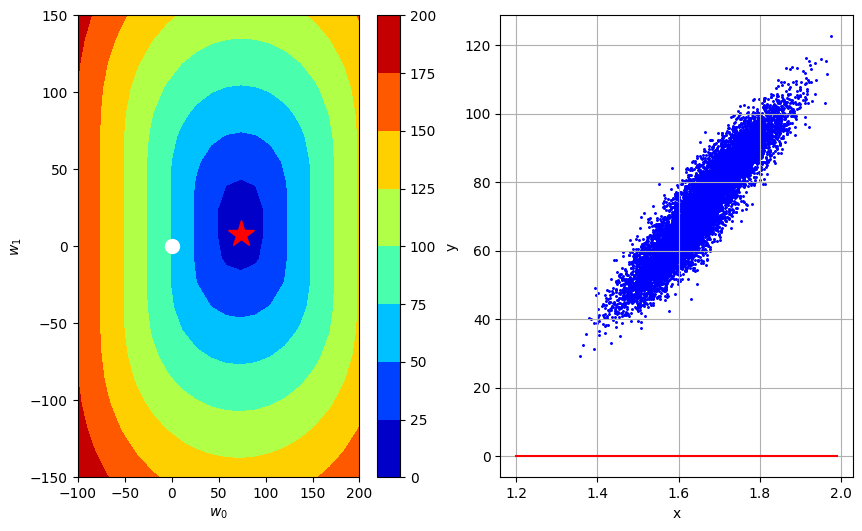

In [24]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

# 5. Effect of Outliers and MAE Cost Function

In [27]:
import datetime
from helpers import *

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: reload the data by subsampling first, then by subsampling and adding outliers
# ***************************************************
height_s, weight_s, gender_s = load_data(sub_sample=True, add_outlier=False)
xs, mean_xs, std_xs = standardize(height_s)
print(mean_xs, std_xs)

ys, txs = build_model_data(xs, weight_s)

height_so, weight_so, gender_so = load_data(sub_sample=True, add_outlier=True)
xso, mean_xso, std_xso = standardize(height_so)
print(mean_xso, std_xso)

yso, txso = build_model_data(xso, weight_so)

1.6646338030124719 0.10474045667514358
1.6595384188242297 0.11611627923801883


In [28]:
y.shape, tx.shape

((202,), (202, 2))

# Subsampled without outliers

In [30]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points
#       and the model fit
# ***************************************************
sgd_s_losses, sgd_s_ws = stochastic_gradient_descent(
    ys, txs, w_initial, batch_size, max_iters, gamma
)


end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=50.19673581577914, w0=35.1377150710454, w1=-51.17160285424769
SGD iter. 1/49: loss=111.23378885449323, w0=113.00136726919067, w1=26.816050039630106
SGD iter. 2/49: loss=51.599004326123115, w0=76.8820642409045, w1=25.352084164892318
SGD iter. 3/49: loss=2.834699121496243, w0=74.89777485585712, w1=24.99818821980191
SGD iter. 4/49: loss=8.406260817375852, w0=69.01339228369403, w1=14.799069435782238
SGD iter. 5/49: loss=14.07345620913803, w0=78.86481163009066, w1=8.357902554348115
SGD iter. 6/49: loss=17.19205945948552, w0=66.83037000845079, w1=14.378571993895061
SGD iter. 7/49: loss=2.768554958644799, w0=68.76835847950214, w1=12.366578527070608
SGD iter. 8/49: loss=13.75910908046636, w0=78.3997348358286, w1=16.140438444808076
SGD iter. 9/49: loss=6.3288034770372406, w0=73.96957240190252, w1=20.655453412661767
SGD iter. 10/49: loss=5.368864200756093, w0=70.21136746137326, w1=17.685514778333
SGD iter. 11/49: loss=0.17981917786870838, w0=70.33724088588136, w1=17.78465886

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

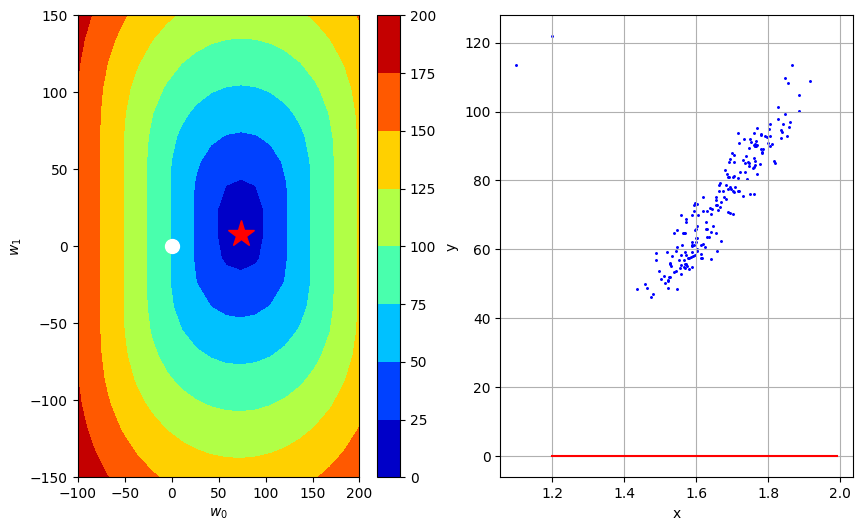

In [31]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# Subsampled with outliers

SGD iter. 0/49: loss=61.176769716949444, w0=42.82373880186461, w1=-26.048221081472672
SGD iter. 1/49: loss=36.41828728326516, w0=68.31653990015022, w1=-22.031282775543804
SGD iter. 2/49: loss=20.540648773017374, w0=53.93808575903806, w1=-13.285359071628486
SGD iter. 3/49: loss=1.4262067189072596, w0=52.939741055802976, w1=-12.65827251407038
SGD iter. 4/49: loss=16.790833256770576, w0=41.186157776063574, w1=-1.2304452073519219
SGD iter. 5/49: loss=22.545147430005514, w0=56.967760977067435, w1=-14.403857511524674
SGD iter. 6/49: loss=33.59634668504893, w0=80.48520365660168, w1=-7.309505304140029
SGD iter. 7/49: loss=7.7049116232151675, w0=85.8786417928523, w1=-5.263976841098363
SGD iter. 8/49: loss=36.65773806785926, w0=60.21822514535083, w1=32.76894671740458
SGD iter. 9/49: loss=23.024882684944615, w0=76.33564302481206, w1=26.887657621046195
SGD iter. 10/49: loss=0.5943273063115981, w0=76.75167213923018, w1=26.81216946795116
SGD iter. 11/49: loss=9.413775317701067, w0=83.34131486162093,

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

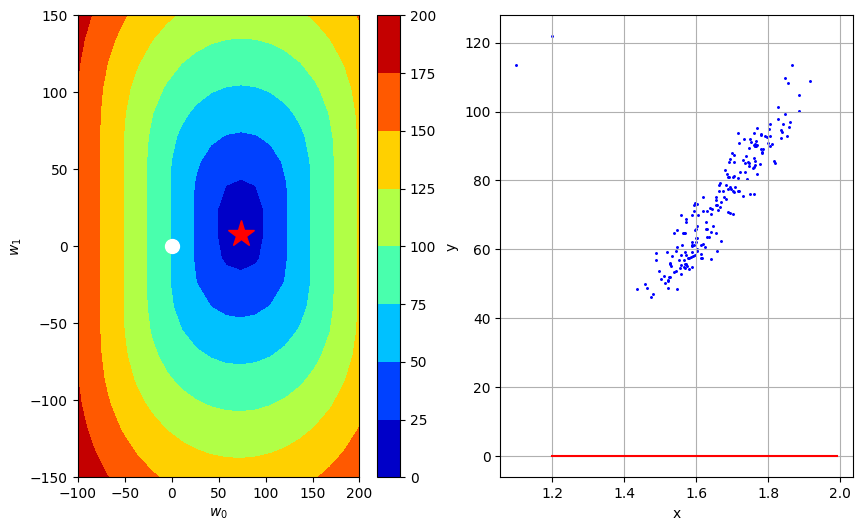

In [32]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points
#       and the model fit
# ***************************************************
sgd_s_losses, sgd_s_ws = stochastic_gradient_descent(
    yso, txso, w_initial, batch_size, max_iters, gamma
)


end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 6. Subgradient descent

In [43]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """

    e = y - tx @ w
    g = - (tx.T @ np.sign(e)) / len(e)

    return g
    

In [48]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute subgradient and loss
        # ***************************************************
        grad = compute_subgradient_mae(y, tx, w)
        loss = compute_loss(y, tx, w, L=mae)
        
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by subgradient
        # ***************************************************
        w = w - gamma * grad

        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [49]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=74.06780585492638, w0=0.7, w1=7.325273501091131e-16
SubGD iter. 1/499: loss=73.36780585492637, w0=1.4, w1=1.4650547002182263e-15
SubGD iter. 2/499: loss=72.66780585492637, w0=2.0999999999999996, w1=2.1975820503273395e-15
SubGD iter. 3/499: loss=71.96780585492638, w0=2.8, w1=2.9301094004364526e-15
SubGD iter. 4/499: loss=71.26780585492638, w0=3.5, w1=3.662636750545566e-15
SubGD iter. 5/499: loss=70.56780585492638, w0=4.2, w1=4.395164100654679e-15
SubGD iter. 6/499: loss=69.86780585492637, w0=4.9, w1=5.1276914507637925e-15
SubGD iter. 7/499: loss=69.16780585492639, w0=5.6000000000000005, w1=5.860218800872906e-15
SubGD iter. 8/499: loss=68.46780585492637, w0=6.300000000000001, w1=6.5927461509820194e-15
SubGD iter. 9/499: loss=67.76780585492638, w0=7.000000000000001, w1=7.325273501091133e-15
SubGD iter. 10/499: loss=67.06780585492638, w0=7.700000000000001, w1=8.057800851200246e-15
SubGD iter. 11/499: loss=66.36780585492637, w0=8.4, w1=8.79032820130936e-15
SubGD iter

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

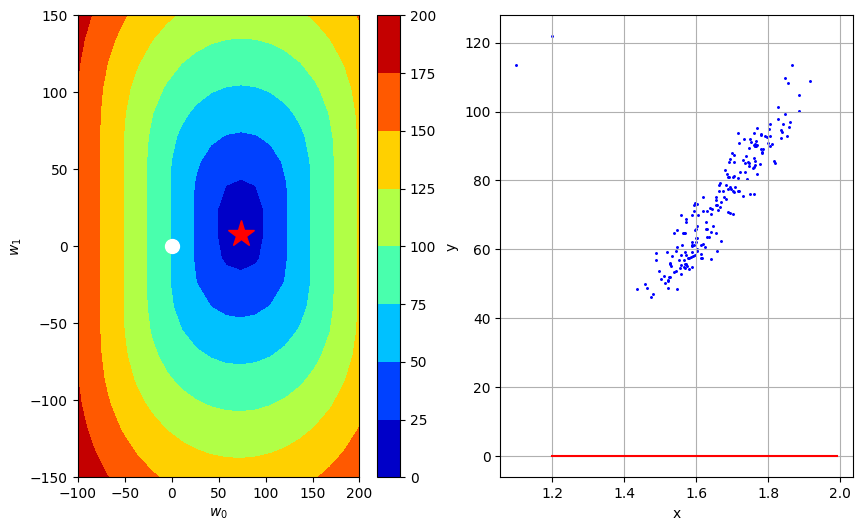

In [50]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [56]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        for y_batch, tx_batch in batch_iter(
            y, tx, batch_size=batch_size, num_batches=1
        ):
            grad = compute_subgradient_mae(y_batch, tx_batch, w)
            loss = compute_loss(y_batch, tx_batch, w, L=mae)
            w = w - gamma * grad

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [57]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=108.82253199045232, w0=0.7, w1=1.5400623383871859
SubSGD iter. 1/499: loss=87.88389386135202, w0=1.4, w1=2.1723367668688764
SubSGD iter. 2/499: loss=65.80181848186447, w0=2.0999999999999996, w1=1.8064160361384791
SubSGD iter. 3/499: loss=56.12732551148317, w0=2.8, w1=1.5212415415891847
SubSGD iter. 4/499: loss=78.72827843712366, w0=3.5, w1=1.8997813249459161
SubSGD iter. 5/499: loss=62.83026528407729, w0=4.2, w1=1.3456742509493353
SubSGD iter. 6/499: loss=69.94534869291375, w0=4.9, w1=0.9635482663990005
SubSGD iter. 7/499: loss=65.27022055981779, w0=5.6000000000000005, w1=1.162309132217525
SubSGD iter. 8/499: loss=82.99979749298049, w0=6.300000000000001, w1=1.6864896836692431
SubSGD iter. 9/499: loss=59.866164674681556, w0=7.000000000000001, w1=1.1021771461233518
SubSGD iter. 10/499: loss=52.10567784913829, w0=7.700000000000001, w1=0.5752201103545039
SubSGD iter. 11/499: loss=85.48242801857907, w0=8.4, w1=1.659095507045806
SubSGD iter. 12/499: loss=66.820492947

interactive(children=(IntSlider(value=1, description='n_iter', max=1, min=1), Output()), _dom_classes=('widget…

<function __main__.plot_figure(n_iter)>

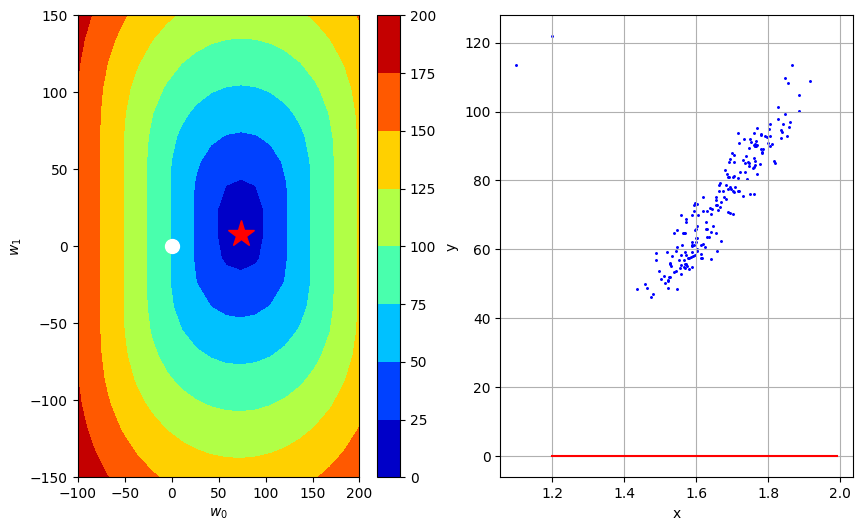

In [58]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))